## 【問題1】コンペティション内容の確認

コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

* 何を学習し、何を予測するのか
* どのようなファイルを作りKaggleに提出するか
* 提出されたものはどういった指標値で評価されるのか

## 【解答】
* 何を学習し、何を予測するのか
    
    * 学習するもの：application_train.csv
    * 予測するもの：SK_ID_CURRごとのTARGET(0:ローン完済, 1:ローン未完済), ROC AUC or F1で評価
    
予測値と観測地の間、ROC(Receiver operating characteristic)カーブ内側の面積を解明
The true positive rate versus the false positive rate (between 0-1)

## 【問題2】学習と検証

データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

＜[参照元](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)＞

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system management
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


## 前処理

In [3]:
app_train = pd.read_csv('../../application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Testing data features
app_test = pd.read_csv('../../application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Exploratory Data Analysis (EDA): 傾向、異常、様式、関係をデータから見抜く
* An open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationship within the data.
* The goal of EDA is to learn what our data can tell us.
* It generally starts out with a high level overview, then narrows in to specific areas.


Target: 
* The target is what we are asked to predict: either 0 (repaid) or 1 (not repaid).

In [49]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

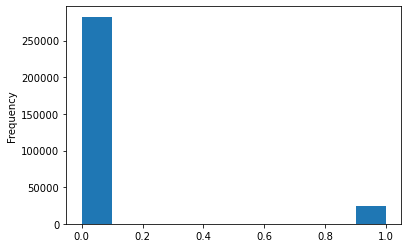

In [50]:
app_train['TARGET'].astype(int).plot.hist();

* The above information is an imbalanced class problem.
    * There are far more loans that were repaid on time.
    * We can 'weight the classes' by their representation in the data to reflect this imbalance.

# 欠損値の算出
* Examine Missing Values
    * We need to look at the number and percentage of missing values in each column.

In [51]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [52]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


* Filling these missing values are essential for our machine learning.
    * Imputation
    * XGBoost (Require no imputation)
    * Drop columns with a high percentage.

# objectをlabel/One-Hot 変換して数値化

* Check the number of unique entries in each of the object (categorical) columns.
    1. Categorical variables require encoding.
    2. For two choices: label encoding.
    3. For more than two choices: One-Hot Encoding.
        * One-Hot Encoding may expand the number of features with many categories.
        * The above problem could be avoidable using PCA or other dimentionality reduction methods.

In [53]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [54]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [55]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [56]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,0,0,0,0,1,0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


# Skipping anomalies（異常値の排除）

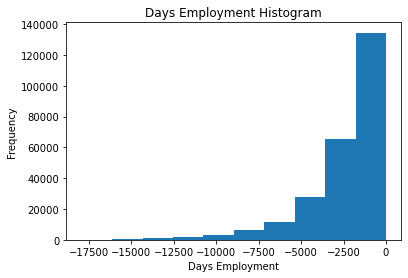

In [57]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [58]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [59]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [60]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

* As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

In [61]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [62]:
# imputer for handling missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [63]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


In [64]:
# Save the submission to a csv file
# submit.to_csv('log_reg_baseline.csv', index = False)

In [39]:
#poly_target = poly_features['TARGET']

#poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
#poly_features = imputer.fit_transform(poly_features)
#poly_features_test = imputer.transform(poly_features_test)

# from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
# poly_transformer = PolynomialFeatures(degree = 3)

In [38]:
# Train the polynomial features
# poly_transformer.fit(poly_features)

# Transform the features
# poly_features = poly_transformer.transform(poly_features)
# poly_features_test = poly_transformer.transform(poly_features_test)
# print('Polynomial Features shape: ', poly_features.shape)

In [ ]:
# poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

## 【問題3】テストデータに対する推定

* テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。

## 【問題4】特徴量エンジニアリング

精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

* どの特徴量を使うか
* どう前処理をするか
* 何をした時に検証データに対する評価指標がどのようになったかをまとめてください。
* 最低5パターンの学習・検証を行ってください。
* 精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

## 【考察】

* どの特徴量を使うか
    * 相関係数から上位5種を選出
* どう前処理をするか
    * objectの数値化
    * 異常値の排除
    * 欠損値の補完
* 何をした時に検証データに対する評価指標がどのようになったかをまとめてください。
* 最低5パターンの学習・検証を行ってください。（アルゴリズムより、特徴量に変化を入れるとよい）
    * ロジスティック回帰
    * 決定木
    * ランダムフォレスト
    * 
    * 
* 精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(train_data, train_label)
importances = model.feature_importances_